This is Part III of the notebook with some experiments in using the Yamnet pre-trained neural network for classifying and evaluating bird audio recordings from the Cacophony project.

See [part I](Yamnet_Audio_Classification_Experiments_Part_1.ipynb) for a full background

Quentin McDonald <br>
September  2021

In [1]:
import csv
import io
import os
import os.path
import glob
import datetime

import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
plt.style.use('seaborn')

from matplotlib import patches
from IPython import display
import pydub
from scipy import signal
import pandas as pd
from tqdm import notebook,trange
import pickle

# Common code moved to utils:
import utils

import score

In [2]:
SAMPLE_RATE = 16000 # Work at 16000 sampling rate
LOW_PASS_CUTOFF = 4000
HIGH_PASS_CUTOFF = 2000
BIRDS_CLASSES = utils.BIRDS_CLASSES

In [3]:
model,class_names = utils.load_model_and_class_names()

2021-09-17 11:37:32.267941: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-17 11:37:36.343671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


<H2> Larger scale testing </H2>

Looking at scoring for all data recorded from the device at my place

In [4]:
def read_cacophony_scores(meta_data_filename):
    """
    Given a CSV file with the meta data in it, read the file and return a dictionary where the keys are the 
    recording IDs and the values are the mean Cacaphony index for the recording
    
    """
    
    cacophony_dict = {}
    
    if os.path.exists(meta_data_filename):
        with open(meta_data_filename) as f:
            recordings_file = csv.DictReader(f)
            for row in recordings_file:
                row_id = int(row["ID"])
                ci = row["Cacophony Index"]
                cis = ci.split(";")
                # Average the first two values:
                cacophony_dict[row_id] = ((float(cis[0])+float(cis[1]))/2.0)

                
    return cacophony_dict

    

In [5]:
def generate_scores_for_directory(directory, model, bird_classes, low_pass_cutoff=None, high_pass_cutoff=None,
                            score_threshold=0.4, top_k_scores = 3,  num_offsets=3, sample_rate=16000,
                                  meta_data_filename = None):
    """
    Generate Yamnet based scores for all the audio files in directory, using the low_pass cutoff and high_pass
    cutoff if they exist. 
    num_offets, score_threshold and top_k_scores are used to control the scoring (see score.score_audio_file())
    
    If a meta data CSV file is specified then the cacophony scores will be read from that. 
    
    Will return a tuple of numpy arrays: (dates, ids, top_class_scores, threshold_scores, cacophony_scores)
    
    """
    
    files = sorted(glob.glob("{}/*.mp4".format(directory)))
    threshold_scores = []
    top_class_scores = []
    dates = []
    ids = []
    caco_scores = []
    
    if meta_data_filename is not None:
        caco_dict = read_cacophony_scores(os.path.join(directory,meta_data_filename))
        
    for i in trange(len(files), ascii=True):
        f = files[i]
        
        top_class_score, threshold_score = score.score_audio_file(f,model=model, bird_classes =bird_classes, 
                                                                  num_offsets = num_offsets, 
                                                                  low_pass_cutoff=low_pass_cutoff, 
                                                               high_pass_cutoff=high_pass_cutoff, 
                                                                  score_threshold=score_threshold, 
                                                                  top_k_scores=top_k_scores,
                                                               sample_rate=sample_rate)
        
       
        #filenames have format <ID>-<DEVICE_NAME>-<YYYYMMDD>-<HHMMSS>.mp4
        # use split to break apart the fields
        fields = f[len(directory):].split("-")
        file_id = int(fields[0])
        if meta_data_filename is not None:
            if file_id not in caco_dict:
                continue   # Skip files that don't have cacophony indices
            else:
                caco_scores.append(caco_dict[file_id])
        
        top_class_scores.append(top_class_score)
        threshold_scores.append(threshold_score)
        
        
       
        ids.append(file_id)
        dates.append(utils.filename_to_date(fields[2]+"-" + fields[3]))
        
        
       
    
    return (np.array(ids),np.array(dates),np.array(top_class_scores),np.array(threshold_scores), 
            np.array(caco_scores))
        
    
    

In [6]:
(ids, dates, top_class_scores, threshold_scores, caco_scores) = generate_scores_for_directory("larger_datasets/qtest_data/", model, BIRDS_CLASSES, num_offsets = 3, 
                              low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF, score_threshold=0.4,
                             top_k_scores = 3, sample_rate = SAMPLE_RATE, meta_data_filename = "qtest_meta.csv")

scores_obj = (ids, dates, top_class_scores, threshold_scores, caco_scores)
with open("larger_datasets/qtest_data/scores.pickle","wb") as f:
    pickle.dump(scores_obj,f)

100%|#######################################| 1122/1122 [15:16<00:00,  1.22it/s]


In [7]:
with open("larger_datasets/qtest_data/scores.pickle","rb") as f:
    (ids, dates, top_class_scores, threshold_scores, caco_scores) = pickle.load(f)

In [8]:
# Compare 5 offsets with 3 offsets:
(ids_5off, dates_5off, top_class_scores_5off, threshold_scores_5off, caco_scores_5off) = generate_scores_for_directory(
    "larger_datasets/qtest_data/", model, BIRDS_CLASSES, num_offsets = 5, low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF, 
    score_threshold=0.4, top_k_scores = 3, sample_rate = SAMPLE_RATE, meta_data_filename = "qtest_meta.csv")


scores_obj_5off = (ids_5off, dates_5off, top_class_scores_5off, threshold_scores_5off, caco_scores_5off)
with open("larger_datasets/qtest_data/scores_5off.pickle","wb") as f:
    pickle.dump(scores_obj_5off,f)

100%|#######################################| 1122/1122 [21:05<00:00,  1.13s/it]


In [9]:
with open("larger_datasets/qtest_data/scores_5off.pickle","rb") as f:
    (ids_5off, dates_5off, top_class_scores_5off, threshold_scores_5off, caco_scores_5off) = pickle.load(f)

In [10]:
def plot_compare_scores( score1, score2, title="", xlabel="", ylabel="", show_45_line=False, 
                        show_regression_line=False):
    """
    Plot a scatter plot of the scores in score1 and score2
    
    Will draw 45 degree (x==y) line if show_45_line is True
    """
    
    fig = plt.figure(2,figsize=(8,8))
    ax = fig.subplots(1)
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    plt.scatter(score1,score2, marker='o', c="#338833")
    if show_45_line:
        ax.axline([0, 0], [1, 1],linewidth=1,c="#DD6666")
    if show_regression_line:
        m, b = np.polyfit(score1, score2, 1)
        x = np.array(score1)
        plt.plot(x, x*m + b, linewidth=2, c="#DDDD33")
        title = title + "\nFit line {:.3f}x + {:.3f}".format(m,b)
        
    ax.set_title(title)
    plt.show()


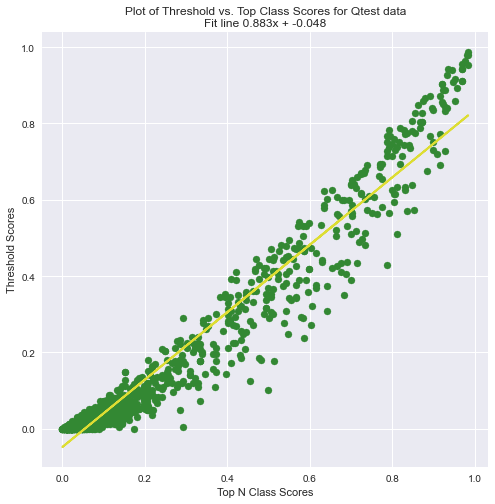

In [11]:
plot_compare_scores(top_class_scores,threshold_scores,"Plot of Threshold vs. Top Class Scores for Qtest data",
                   "Top N Class Scores", "Threshold Scores",show_45_line=False,show_regression_line = True )

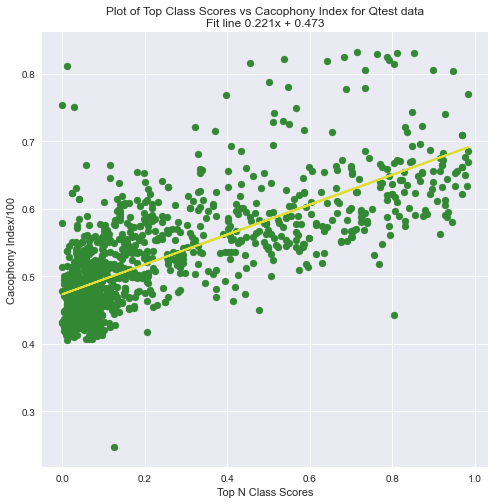

In [12]:
caco_frac = caco_scores/100.0
plot_compare_scores(top_class_scores,caco_frac,"Plot of Top Class Scores vs Cacophony Index for Qtest data",
                   "Top N Class Scores", "Cacophony Index/100",show_45_line=False,show_regression_line = True )

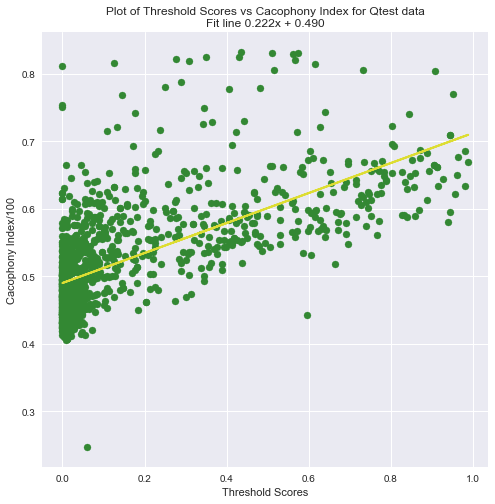

In [13]:

plot_compare_scores(threshold_scores,caco_frac,"Plot of Threshold Scores vs Cacophony Index for Qtest data",
                   "Threshold Scores", "Cacophony Index/100",show_45_line=False,show_regression_line = True )

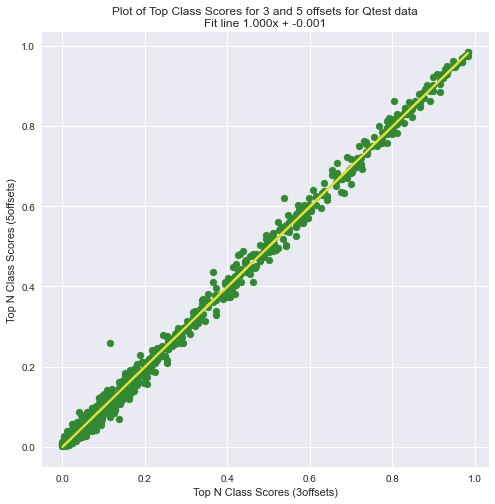

In [14]:
# Effect of number of offsets:
plot_compare_scores(top_class_scores,top_class_scores_5off,"Plot of Top Class Scores for 3 and 5 offsets for Qtest data",
                   "Top N Class Scores (3offsets)", "Top N Class Scores (5offsets)",show_45_line=False,show_regression_line = True )

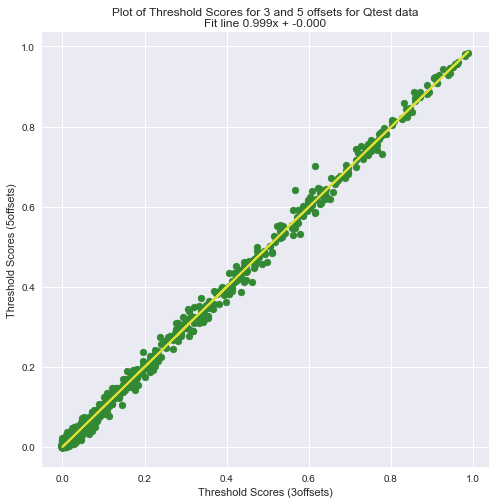

In [15]:
plot_compare_scores(threshold_scores,threshold_scores_5off,"Plot of Threshold Scores for 3 and 5 offsets for Qtest data",
                   "Threshold Scores (3offsets)", "Threshold Scores (5offsets)",show_45_line=False,show_regression_line = True )

<H3> Top Scores by Each Method </H3>
Examine audio files giving the top scores for each method

In [16]:
def print_top_k_scores(scores,k, ids, dates, title=""):
    """
    For bird scores in "scores", print a record of the top-K scores, including links to the recording
    based on data in ids and dates
    """
    idx = np.argsort(-scores)[:k]
    
    print(title)
    print()
    print("{:20s} {:5s}     {:40s}".format("Date","Score","Link"))
    print("{:20s}-{:5s}-----{:40s}".format("-"*20,"-"*5,"-"*40))
    for i in idx:
            date = dates[i].strftime("%d-%b-%Y %H:%M:%S")
            link = "https://browse.cacophony.org.nz/recording/{}".format(ids[i])
            print("{:20s} {:5.2f}     {:40s}".format(date, scores[i], link))
    

In [17]:
NUM_TOP = 10
print_top_k_scores(top_class_scores, NUM_TOP, ids,dates,"Top N Class Scores for QTest")

Top N Class Scores for QTest

Date                 Score     Link                                    
-----------------------------------------------------------------------
14-Sep-2021 13:43:57  0.98     https://browse.cacophony.org.nz/recording/937490
08-Sep-2021 07:27:47  0.98     https://browse.cacophony.org.nz/recording/932245
13-Sep-2021 16:07:01  0.98     https://browse.cacophony.org.nz/recording/936985
15-Sep-2021 06:28:18  0.98     https://browse.cacophony.org.nz/recording/937963
07-Sep-2021 16:55:56  0.98     https://browse.cacophony.org.nz/recording/931527
15-Sep-2021 10:56:33  0.98     https://browse.cacophony.org.nz/recording/938067
05-Sep-2021 17:57:16  0.97     https://browse.cacophony.org.nz/recording/930160
10-Sep-2021 06:10:00  0.97     https://browse.cacophony.org.nz/recording/934648
10-Sep-2021 06:10:00  0.97     https://browse.cacophony.org.nz/recording/934634
08-Sep-2021 16:23:29  0.97     https://browse.cacophony.org.nz/recording/932750


In [18]:
print_top_k_scores(threshold_scores, NUM_TOP, ids,dates,"Top Threshold Scores for QTest")

Top Threshold Scores for QTest

Date                 Score     Link                                    
-----------------------------------------------------------------------
13-Sep-2021 16:07:01  0.99     https://browse.cacophony.org.nz/recording/936985
08-Sep-2021 07:27:47  0.98     https://browse.cacophony.org.nz/recording/932245
15-Sep-2021 06:28:18  0.98     https://browse.cacophony.org.nz/recording/937963
15-Sep-2021 10:56:33  0.96     https://browse.cacophony.org.nz/recording/938067
07-Sep-2021 16:55:56  0.96     https://browse.cacophony.org.nz/recording/931527
05-Sep-2021 17:57:16  0.96     https://browse.cacophony.org.nz/recording/930160
14-Sep-2021 13:43:57  0.95     https://browse.cacophony.org.nz/recording/937490
08-Sep-2021 16:23:29  0.94     https://browse.cacophony.org.nz/recording/932750
14-Sep-2021 14:32:22  0.94     https://browse.cacophony.org.nz/recording/937502
08-Sep-2021 16:23:29  0.94     https://browse.cacophony.org.nz/recording/932751


In [19]:
print_top_k_scores(caco_scores, NUM_TOP, ids,dates,"Top Cacophony Index Scores for QTest")

Top Cacophony Index Scores for QTest

Date                 Score     Link                                    
-----------------------------------------------------------------------
13-Sep-2021 05:13:05 83.30     https://browse.cacophony.org.nz/recording/936726
13-Sep-2021 05:56:51 83.15     https://browse.cacophony.org.nz/recording/936738
13-Sep-2021 05:54:16 83.10     https://browse.cacophony.org.nz/recording/936734
14-Sep-2021 10:19:02 83.00     https://browse.cacophony.org.nz/recording/937435
02-Sep-2021 09:30:21 82.50     https://browse.cacophony.org.nz/recording/926656
14-Sep-2021 10:13:04 82.50     https://browse.cacophony.org.nz/recording/937424
14-Sep-2021 01:14:09 82.20     https://browse.cacophony.org.nz/recording/937214
13-Sep-2021 06:48:53 82.00     https://browse.cacophony.org.nz/recording/936760
14-Sep-2021 05:15:43 81.90     https://browse.cacophony.org.nz/recording/937329
12-Aug-2021 07:45:34 81.65     https://browse.cacophony.org.nz/recording/909965


<H3> Averaging scores per hour of the day over the whole dataset </H3>


In [20]:

def plot_average_per_hour_score( dates, class_scores, threshold_scores, cacophony_scores, title=""):
    """
    Create a plot of the mean score for each hour of the day over the entire dataset
    
    
    """
    
    class_data = []
    threshold_data = []
    caco_data = []
    for i in range(24):
        class_data.append([])
        threshold_data.append([])
        caco_data.append([])
    
  
    for i,d in enumerate(dates):
        hour = d.hour
        class_data[hour].append(class_scores[i])
        threshold_data[hour].append(threshold_scores[i])
        caco_data[hour].append(cacophony_scores[i])
     
    class_data_mean = np.zeros((24,), dtype='float')
    thresh_data_mean = np.zeros((24,), dtype='float')
    caco_data_mean = np.zeros((24,), dtype='float')
    class_data_sd = np.zeros((24,), dtype='float')
    thresh_data_sd = np.zeros((24,), dtype='float')
    caco_data_sd = np.zeros((24,), dtype='float')
    hours = []
    for i in range(24):
        hours.append(i)
        class_data_mean[i] = np.mean(np.array(class_data[i]))
        thresh_data_mean[i] = np.mean(np.array(threshold_data[i]))
        caco_data_mean[i] = np.mean(np.array(caco_data[i]))
      
    
    fig = plt.figure(2,figsize=(15,10),dpi=300)
    ax = fig.subplots(1)
    ax.set_title(title)
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Score")
    ax.xaxis.set_major_locator(MultipleLocator(3))
    lns1=ax.plot(hours,class_data_mean,c='#AA55AA',linewidth=3,label='Class Score',marker='o')
    lns2=ax.plot(hours,thresh_data_mean,c='#55AAAA',linewidth=3,label='Threshold Score',marker='o')
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    lns3 = ax2.plot(hours,caco_data_mean,c='#AAAA55',linewidth=3,label='Cacophony Index',marker='o')
    ax2.set_ylabel("Cacophony Index")
        
    lns = lns1+lns2 + lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)
    plt.show()
    

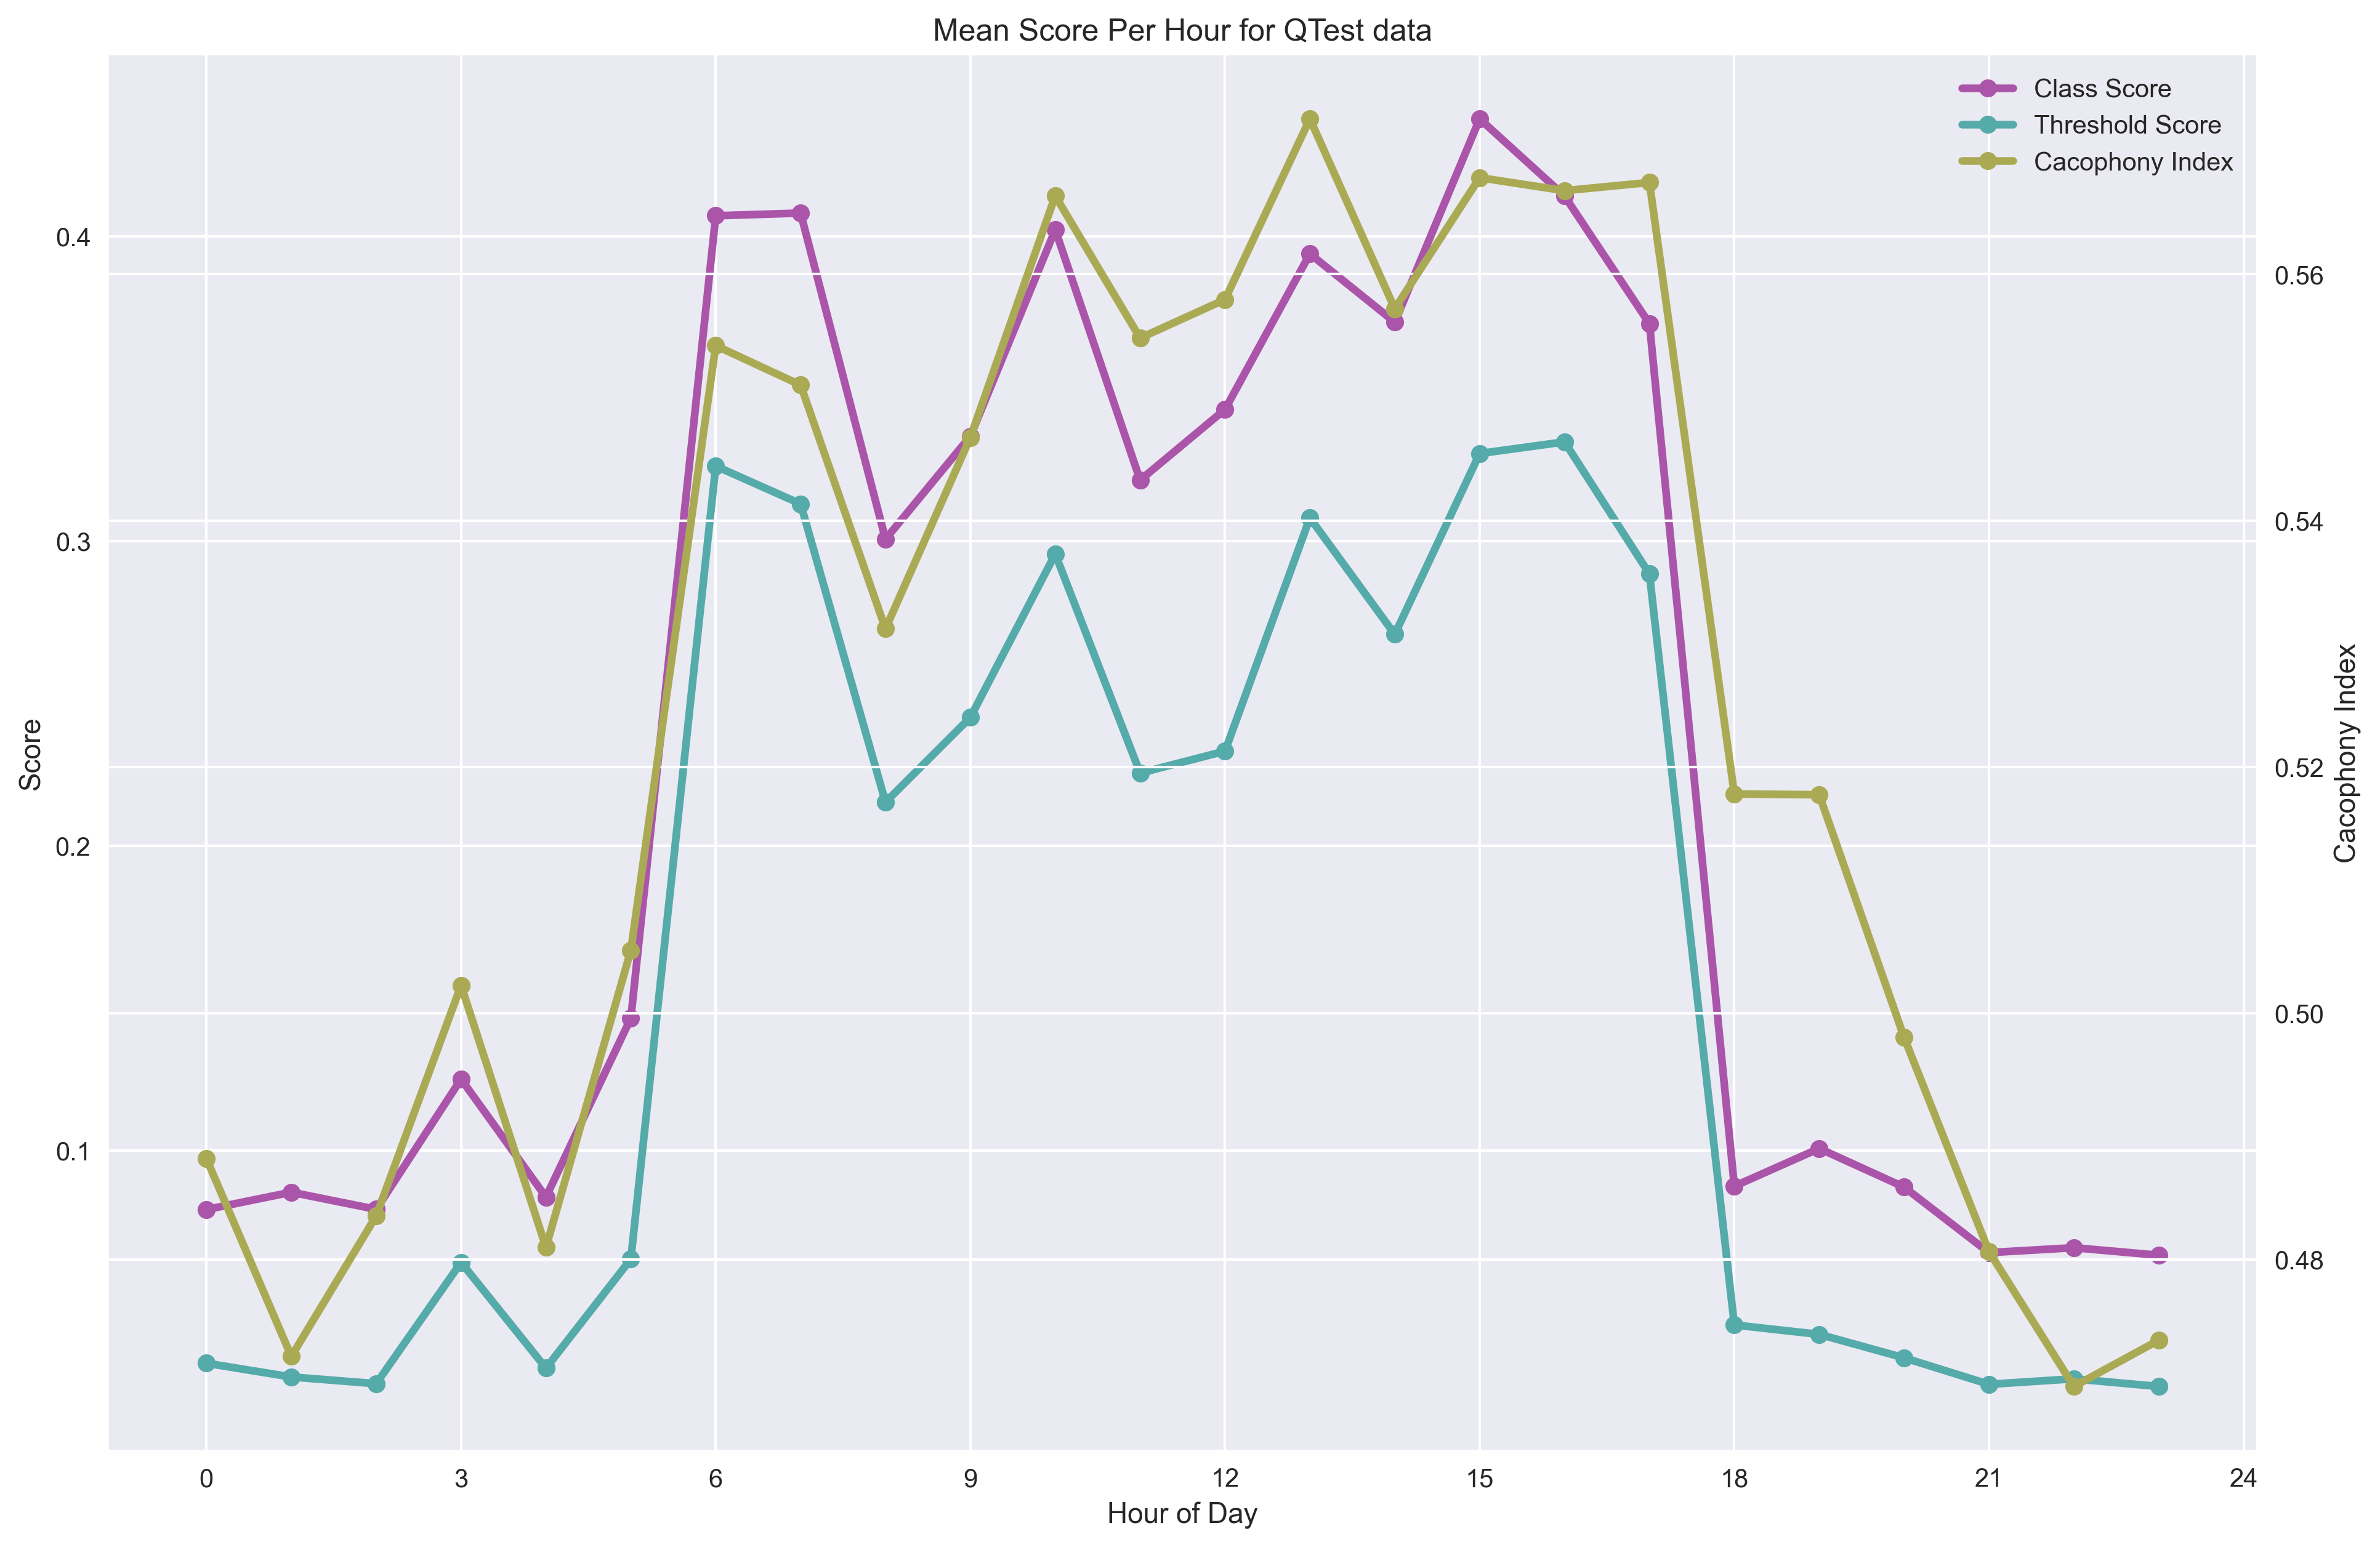

In [21]:
plot_average_per_hour_score(dates, top_class_scores, threshold_scores, caco_frac,
                           title= "Mean Score Per Hour for QTest data")

  <H3> Similar analysis with data from Grant's Shed for August 2021 </H3>

In [23]:
# (gs_aug21_ids, gs_aug21_dates, gs_aug21_top_class_scores, 
#  gs_aug21_threshold_scores, gs_aug21_caco_scores) = generate_scores_for_directory("larger_datasets/gs_aug21/", model, BIRDS_CLASSES, num_offsets = 3, 
#                               low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF, score_threshold=0.4,
#                              top_k_scores = 3, sample_rate = SAMPLE_RATE, meta_data_filename = "gs_aug21_meta.csv")

# scores_obj = (gs_aug21_ids, gs_aug21_dates, gs_aug21_top_class_scores, 
#  gs_aug21_threshold_scores, gs_aug21_caco_scores)
# with open("larger_datasets/gs_aug21/scores.pickle","wb") as f:
#     pickle.dump(scores_obj,f)

In [31]:
with open("larger_datasets/gs_aug21/scores.pickle","rb") as f:
    (gs_aug21_ids, gs_aug21_dates, gs_aug21_top_class_scores,gs_aug21_threshold_scores, 
     gs_aug21_caco_scores) = pickle.load(f)

gs_aug21_caco_frac = gs_aug21_caco_scores/100.0

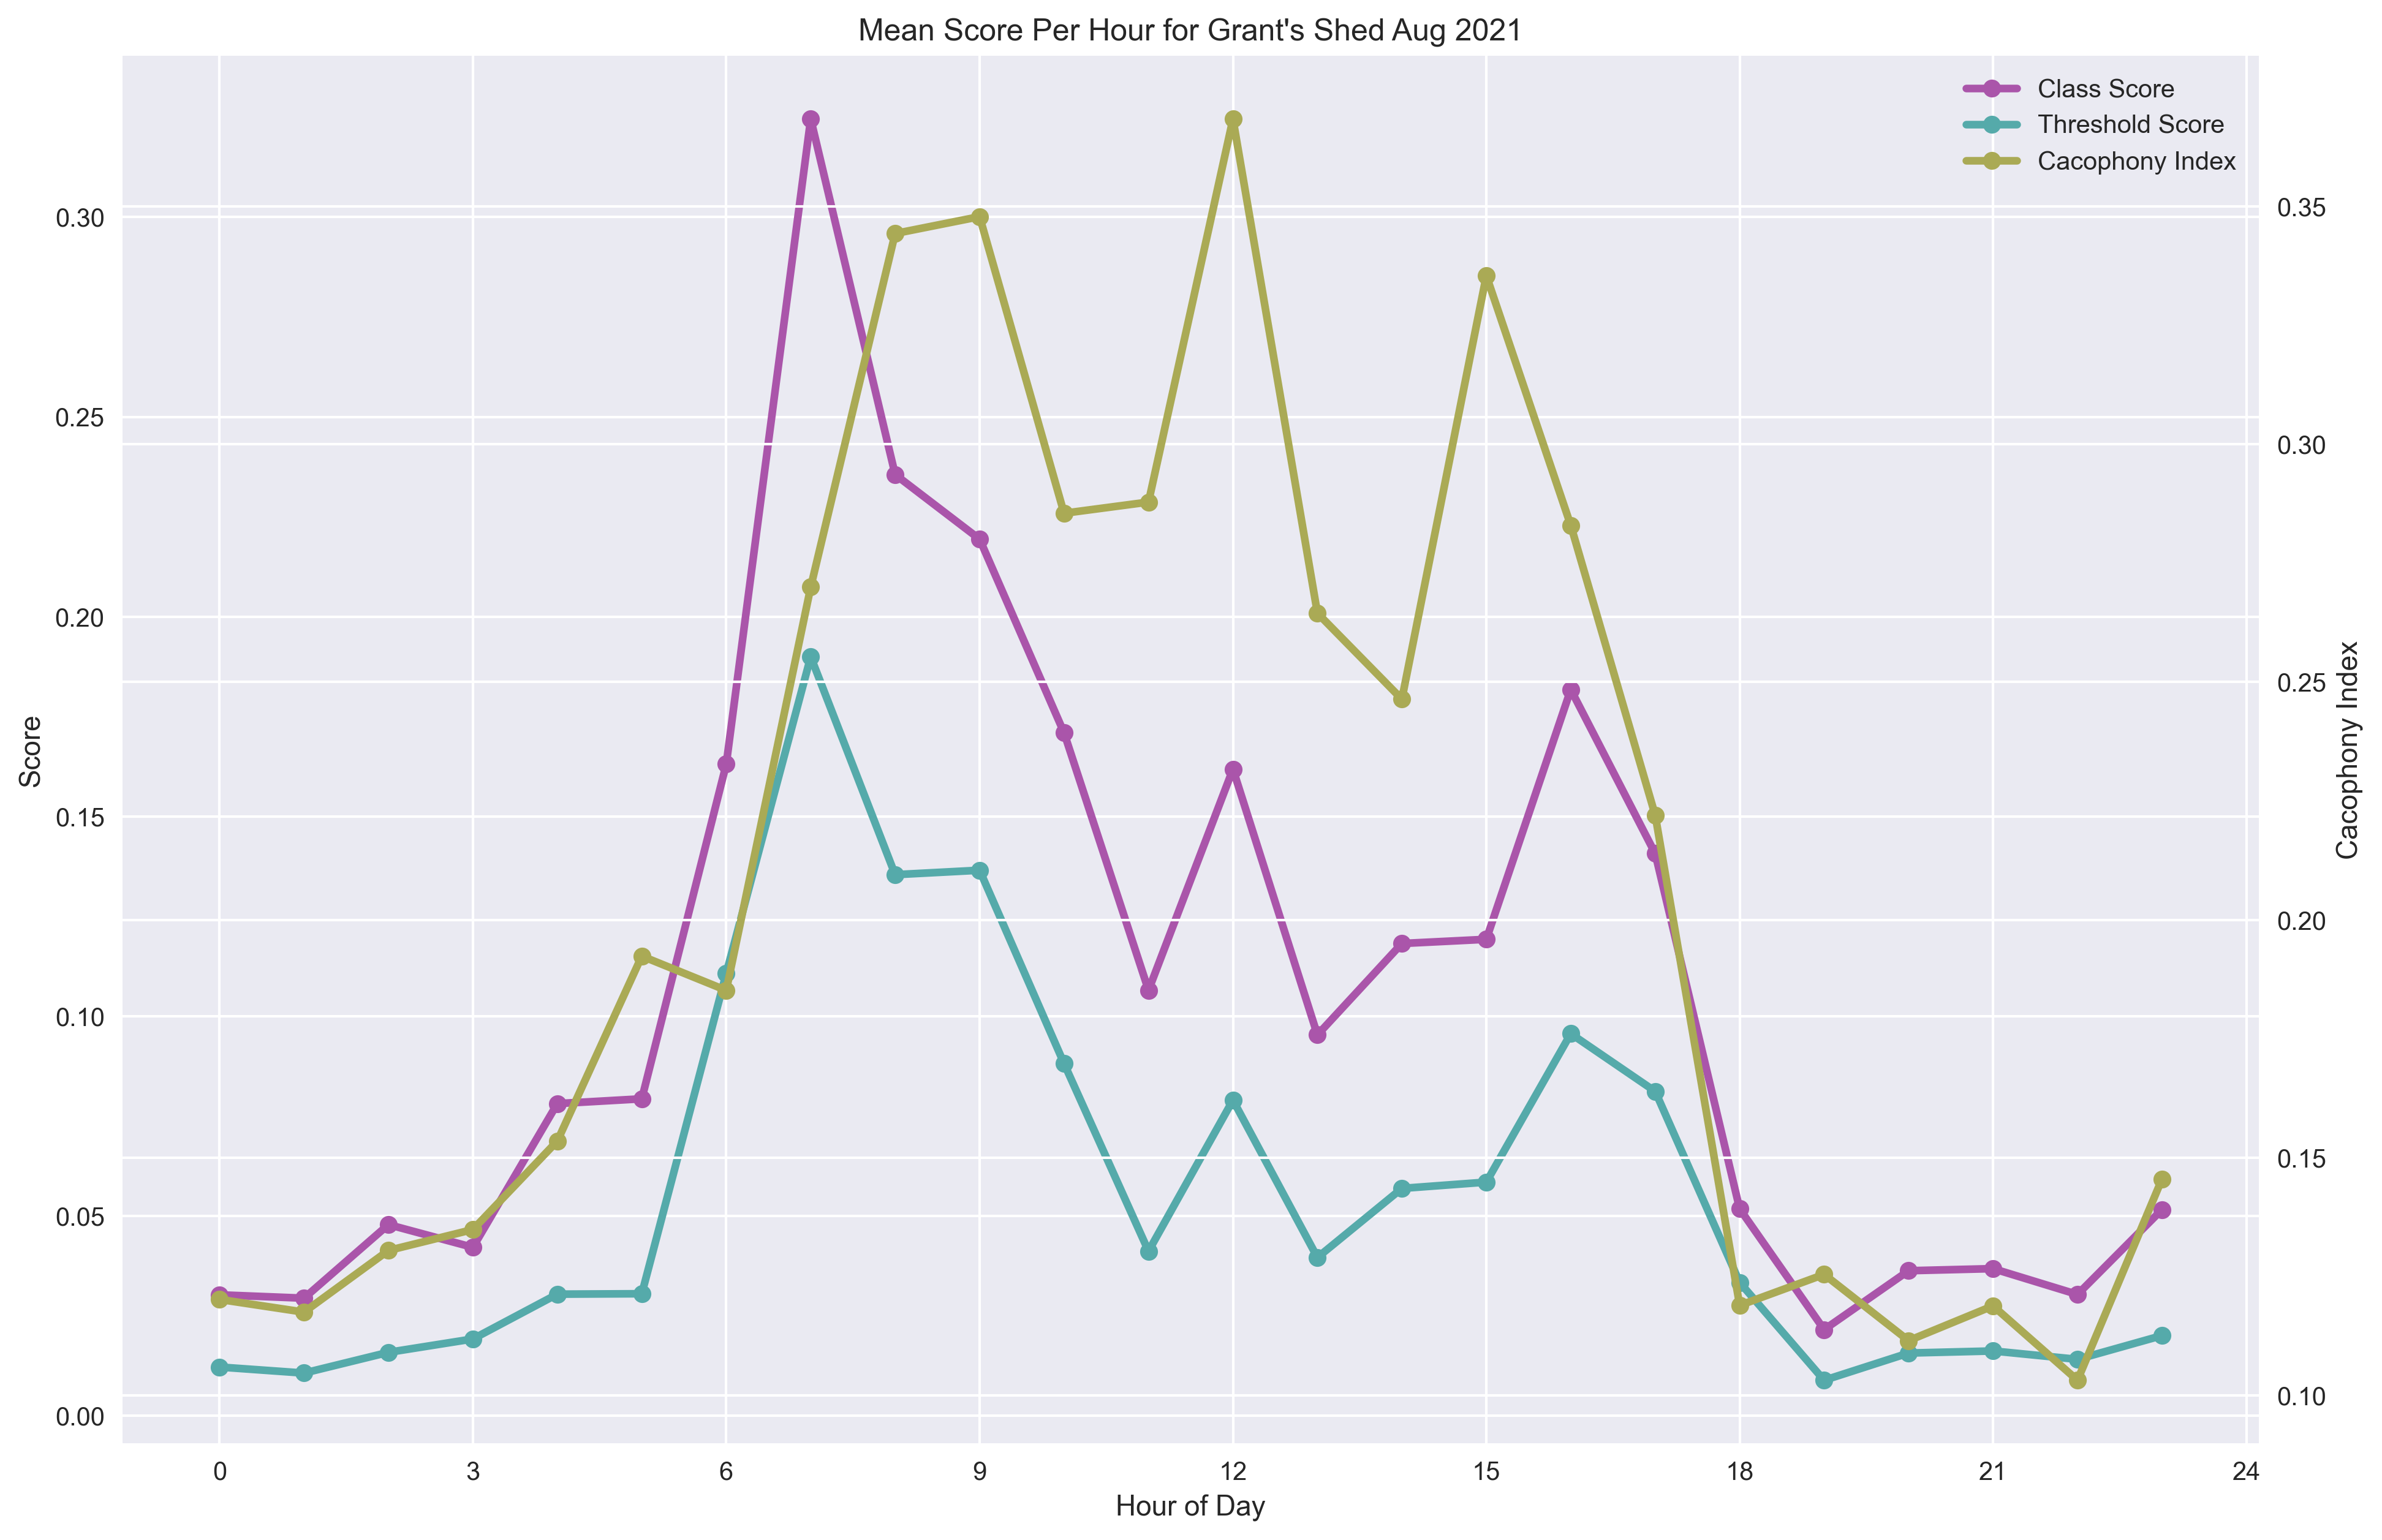

In [32]:

plot_average_per_hour_score(gs_aug21_dates, gs_aug21_top_class_scores, gs_aug21_threshold_scores, gs_aug21_caco_frac,
                           title= "Mean Score Per Hour for Grant's Shed Aug 2021")

In [33]:
print_top_k_scores(gs_aug21_top_class_scores, NUM_TOP, gs_aug21_ids,gs_aug21_dates,"Top N Class Scores for Grant's Shed Aug 2021")

Top N Class Scores for Grant's Shed Aug 2021

Date                 Score     Link                                    
-----------------------------------------------------------------------
24-Aug-2021 07:35:13  0.98     https://browse.cacophony.org.nz/recording/921129
20-Aug-2021 18:06:00  0.98     https://browse.cacophony.org.nz/recording/918128
20-Aug-2021 06:58:00  0.97     https://browse.cacophony.org.nz/recording/917639
21-Aug-2021 06:57:03  0.94     https://browse.cacophony.org.nz/recording/918577
23-Aug-2021 10:44:28  0.94     https://browse.cacophony.org.nz/recording/920449
23-Aug-2021 06:57:03  0.93     https://browse.cacophony.org.nz/recording/920234
22-Aug-2021 07:17:04  0.93     https://browse.cacophony.org.nz/recording/919540
20-Aug-2021 07:38:01  0.93     https://browse.cacophony.org.nz/recording/917643
16-Aug-2021 06:57:03  0.93     https://browse.cacophony.org.nz/recording/914817
17-Aug-2021 07:05:02  0.93     https://browse.cacophony.org.nz/recording/914869


In [34]:
print_top_k_scores(gs_aug21_threshold_scores, NUM_TOP, gs_aug21_ids,gs_aug21_dates,"Top Threshold Scores for Grant's Shed Aug 2021")

Top Threshold Scores for Grant's Shed Aug 2021

Date                 Score     Link                                    
-----------------------------------------------------------------------
24-Aug-2021 07:35:13  0.93     https://browse.cacophony.org.nz/recording/921129
23-Aug-2021 10:44:28  0.92     https://browse.cacophony.org.nz/recording/920449
21-Aug-2021 07:06:00  0.89     https://browse.cacophony.org.nz/recording/918579
19-Aug-2021 17:35:00  0.88     https://browse.cacophony.org.nz/recording/917265
22-Aug-2021 07:17:04  0.88     https://browse.cacophony.org.nz/recording/919540
20-Aug-2021 06:58:00  0.88     https://browse.cacophony.org.nz/recording/917639
23-Aug-2021 06:57:03  0.87     https://browse.cacophony.org.nz/recording/920234
22-Aug-2021 06:45:00  0.86     https://browse.cacophony.org.nz/recording/919537
20-Aug-2021 07:08:00  0.86     https://browse.cacophony.org.nz/recording/917640
23-Aug-2021 06:43:00  0.83     https://browse.cacophony.org.nz/recording/920233


In [35]:
print_top_k_scores(gs_aug21_caco_scores, NUM_TOP, gs_aug21_ids,gs_aug21_dates,"Top Cacophony Index for Grant's Shed Aug 2021")

Top Cacophony Index for Grant's Shed Aug 2021

Date                 Score     Link                                    
-----------------------------------------------------------------------
06-Aug-2021 08:12:14 79.10     https://browse.cacophony.org.nz/recording/914358
20-Aug-2021 07:38:01 78.05     https://browse.cacophony.org.nz/recording/917643
10-Aug-2021 14:42:06 77.20     https://browse.cacophony.org.nz/recording/914556
10-Aug-2021 13:42:06 77.10     https://browse.cacophony.org.nz/recording/914555
10-Aug-2021 09:04:09 76.80     https://browse.cacophony.org.nz/recording/914548
20-Aug-2021 08:49:06 76.70     https://browse.cacophony.org.nz/recording/917645
04-Aug-2021 12:15:23 74.75     https://browse.cacophony.org.nz/recording/914270
10-Aug-2021 12:39:19 74.20     https://browse.cacophony.org.nz/recording/914554
15-Aug-2021 15:35:04 73.30     https://browse.cacophony.org.nz/recording/914785
20-Aug-2021 07:28:00 72.55     https://browse.cacophony.org.nz/recording/917642


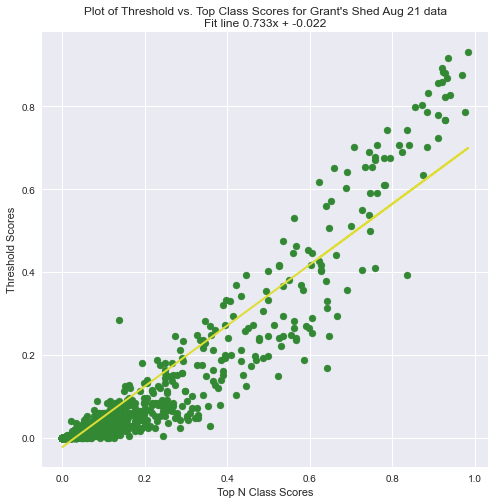

In [36]:
plot_compare_scores(gs_aug21_top_class_scores,gs_aug21_threshold_scores,
                    "Plot of Threshold vs. Top Class Scores for Grant's Shed Aug 21 data",
                   "Top N Class Scores", "Threshold Scores",show_45_line=False,show_regression_line = True )

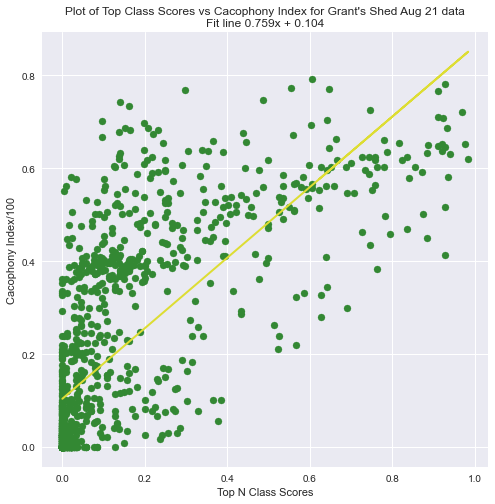

In [37]:
plot_compare_scores(gs_aug21_top_class_scores,gs_aug21_caco_frac,
                    "Plot of Top Class Scores vs Cacophony Index for Grant's Shed Aug 21 data",
                   "Top N Class Scores", "Cacophony Index/100",show_45_line=False,show_regression_line = True )

  <H3> Similar analysis with data from Grant's Shed for Jan 2019 </H3>

In [38]:
# (gs_jan19_ids, gs_jan19_dates, gs_jan19_top_class_scores, 
# gs_jan19_threshold_scores, gs_jan19_caco_scores) = generate_scores_for_directory("larger_datasets/gs_jan19/", model, BIRDS_CLASSES, num_offsets = 3, 
#                              low_pass_cutoff=LOW_PASS_CUTOFF,high_pass_cutoff=HIGH_PASS_CUTOFF, score_threshold=0.4,
#                             top_k_scores = 3, sample_rate = SAMPLE_RATE, meta_data_filename = "gs_jan19_meta.csv")

# scores_obj = (gs_jan19_ids, gs_jan19_dates, gs_jan19_top_class_scores, 
#  gs_jan19_threshold_scores, gs_jan19_caco_scores)
# with open("larger_datasets/gs_jan19/scores.pickle","wb") as f:
#     pickle.dump(scores_obj,f)


100%|#######################################| 1319/1319 [16:37<00:00,  1.32it/s]


In [39]:

with open("larger_datasets/gs_jan19/scores.pickle","rb") as f:
    (gs_jan19_ids, gs_jan19_dates, gs_jan19_top_class_scores, 
         gs_jan19_threshold_scores, gs_jan19_caco_scores) = pickle.load(f)

gs_jan19_caco_frac = gs_jan19_caco_scores/100.0

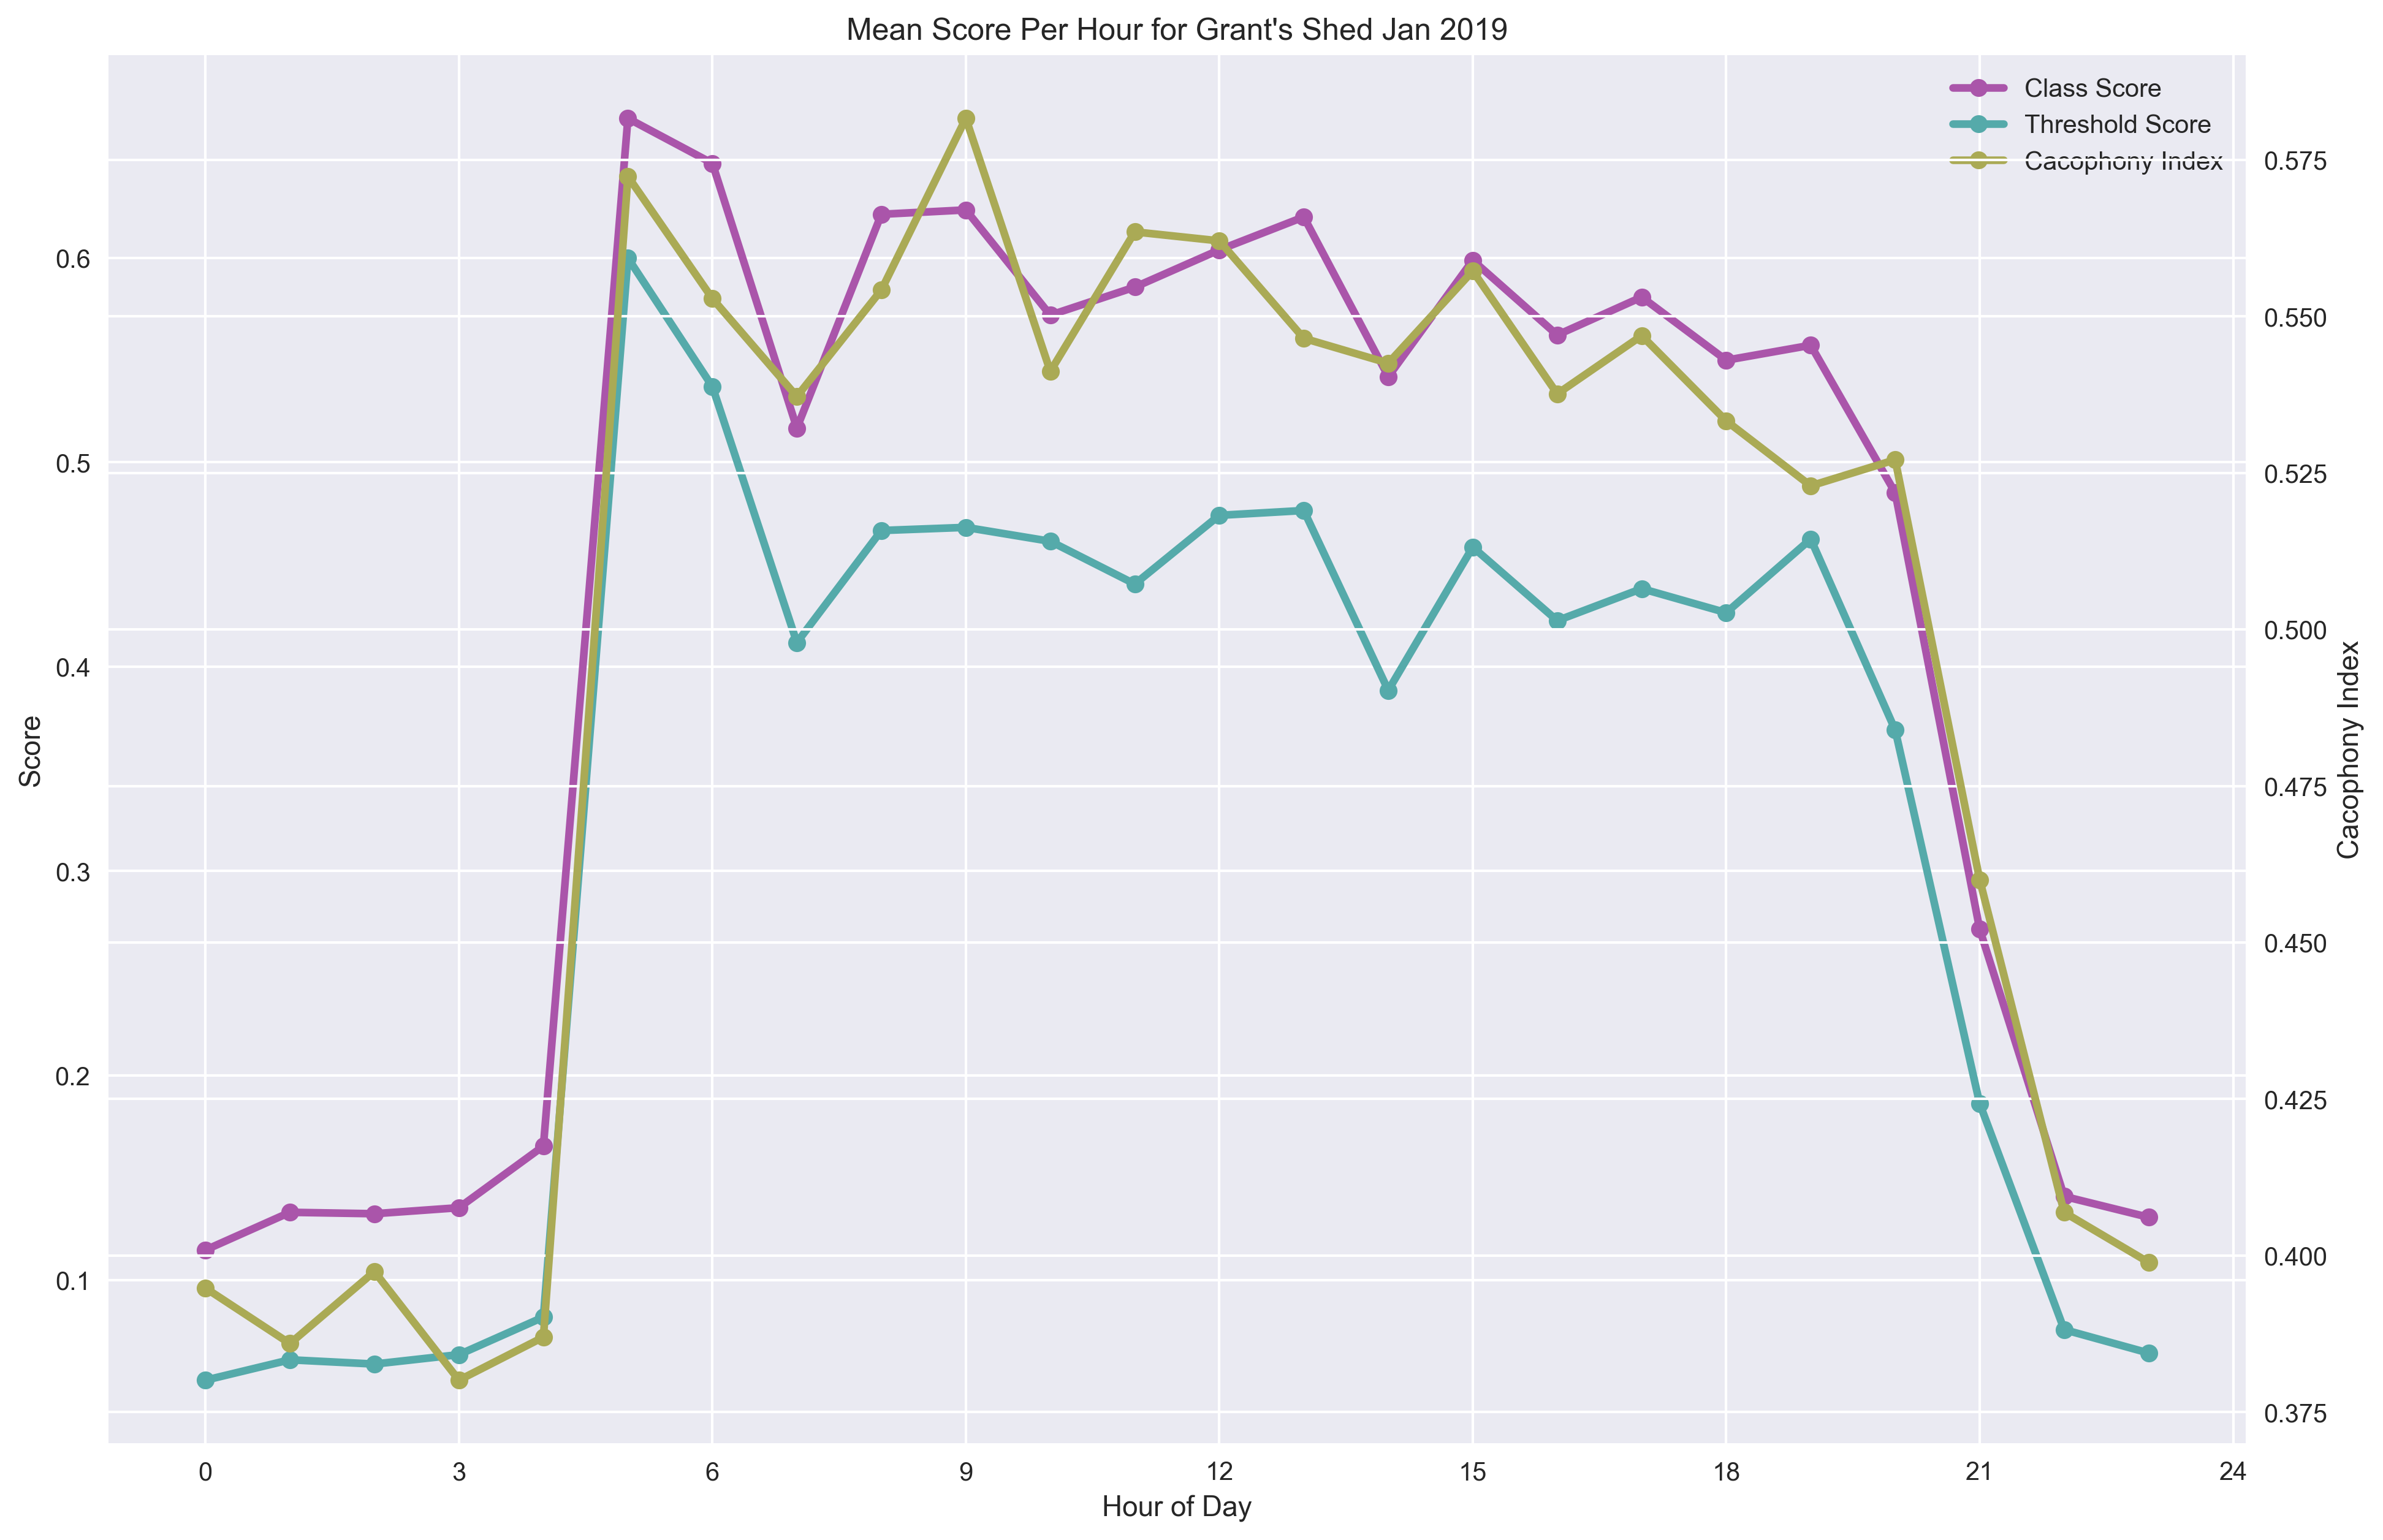

In [40]:
plot_average_per_hour_score(gs_jan19_dates, gs_jan19_top_class_scores, gs_jan19_threshold_scores, 
                            gs_jan19_caco_frac,
                           title= "Mean Score Per Hour for Grant's Shed Jan 2019")

In [41]:
print_top_k_scores(gs_jan19_top_class_scores, NUM_TOP, gs_jan19_ids,gs_jan19_dates,"Top N Class Scores for Grant's Shed Jan 2019")

Top N Class Scores for Grant's Shed Jan 2019

Date                 Score     Link                                    
-----------------------------------------------------------------------
10-Jan-2019 09:39:00  0.99     https://browse.cacophony.org.nz/recording/236861
20-Jan-2019 05:41:42  0.99     https://browse.cacophony.org.nz/recording/237304
14-Jan-2019 05:43:00  0.99     https://browse.cacophony.org.nz/recording/237035
10-Jan-2019 05:19:00  0.99     https://browse.cacophony.org.nz/recording/236850
21-Jan-2019 05:40:00  0.99     https://browse.cacophony.org.nz/recording/237349
23-Jan-2019 05:43:00  0.99     https://browse.cacophony.org.nz/recording/237439
10-Jan-2019 14:20:17  0.99     https://browse.cacophony.org.nz/recording/236866
09-Jan-2019 05:28:00  0.99     https://browse.cacophony.org.nz/recording/236806
06-Jan-2019 05:15:00  0.99     https://browse.cacophony.org.nz/recording/236670
25-Jan-2019 05:55:00  0.99     https://browse.cacophony.org.nz/recording/237530


In [42]:
print_top_k_scores(gs_jan19_threshold_scores, NUM_TOP, gs_jan19_ids,gs_jan19_dates,"Top Threshold Scores for Grant's Shed Jan 2019")

Top Threshold Scores for Grant's Shed Jan 2019

Date                 Score     Link                                    
-----------------------------------------------------------------------
21-Jan-2019 05:40:00  0.99     https://browse.cacophony.org.nz/recording/237349
11-Jan-2019 05:20:00  0.99     https://browse.cacophony.org.nz/recording/236895
27-Jan-2019 05:47:00  0.99     https://browse.cacophony.org.nz/recording/237619
10-Jan-2019 14:20:17  0.99     https://browse.cacophony.org.nz/recording/236866
10-Jan-2019 09:39:00  0.99     https://browse.cacophony.org.nz/recording/236861
10-Jan-2019 05:19:00  0.99     https://browse.cacophony.org.nz/recording/236850
23-Jan-2019 05:43:00  0.99     https://browse.cacophony.org.nz/recording/237439
06-Jan-2019 05:15:00  0.98     https://browse.cacophony.org.nz/recording/236670
20-Jan-2019 05:41:42  0.98     https://browse.cacophony.org.nz/recording/237304
14-Jan-2019 05:43:00  0.98     https://browse.cacophony.org.nz/recording/237035


In [43]:
print_top_k_scores(gs_jan19_caco_scores, NUM_TOP, gs_jan19_ids,gs_jan19_dates,"Top Cacophony Index Scores for Grant's Shed Jan 2019")

Top Cacophony Index Scores for Grant's Shed Jan 2019

Date                 Score     Link                                    
-----------------------------------------------------------------------
11-Jan-2019 09:40:03 79.00     https://browse.cacophony.org.nz/recording/236906
02-Jan-2019 08:32:03 76.55     https://browse.cacophony.org.nz/recording/236498
26-Jan-2019 06:16:00 74.80     https://browse.cacophony.org.nz/recording/237577
05-Jan-2019 11:37:19 74.45     https://browse.cacophony.org.nz/recording/236638
25-Jan-2019 05:55:00 72.55     https://browse.cacophony.org.nz/recording/237530
11-Jan-2019 17:16:24 72.25     https://browse.cacophony.org.nz/recording/236914
27-Jan-2019 18:13:32 72.00     https://browse.cacophony.org.nz/recording/237638
26-Jan-2019 06:06:00 71.85     https://browse.cacophony.org.nz/recording/237576
24-Jan-2019 15:30:40 71.10     https://browse.cacophony.org.nz/recording/237500
01-Jan-2019 05:23:00 70.65     https://browse.cacophony.org.nz/recording/236443
